In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calibrate_camera():
    nx, ny = 9, 6
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objpoints = []
    imgpoints = []
    images = glob.glob('camera_cal/calibration*.jpg')
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

def undistort(img, mtx, dist):
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undistorted

mtx, dist = calibrate_camera()

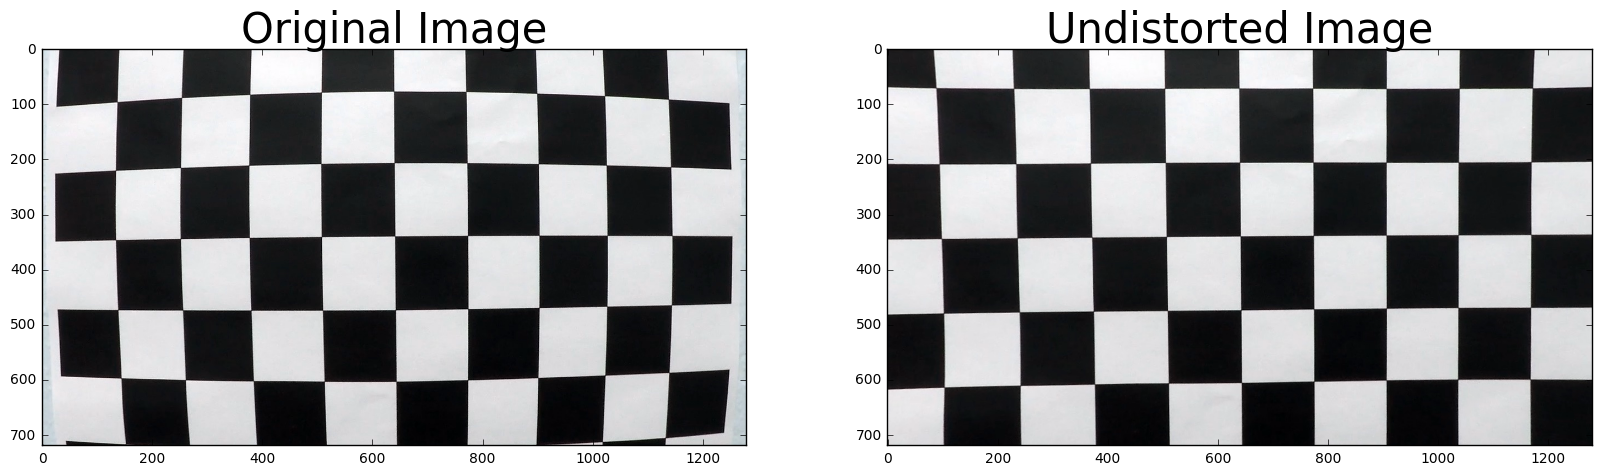

In [3]:
def show_two_images(img1, img2, title1, title2):
    cmap = None if len(img1.shape) == 3 else 'gray'
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1, cmap=cmap)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title(title2, fontsize=30)

img = cv2.imread('camera_cal/calibration1.jpg')


img_undistorted = undistort(img, mtx, dist)

cv2.imwrite('camera_cal/calibration1_undist.jpg', img_undistorted)

show_two_images(img, img_undistorted, 'Original Image', 'Undistorted Image')

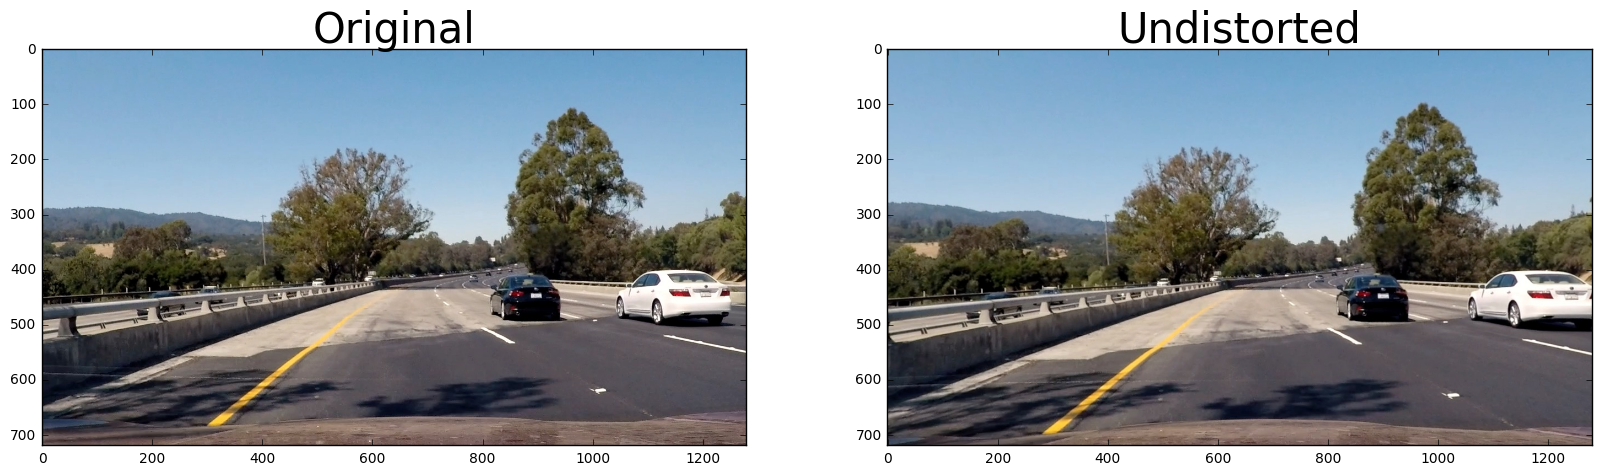

In [4]:
img_file = 'test_images/test4.jpg'
test_image = cv2.imread(img_file)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
undist_ti = undistort(test_image, mtx, dist)
show_two_images(test_image, undist_ti, 'Original', 'Undistorted')


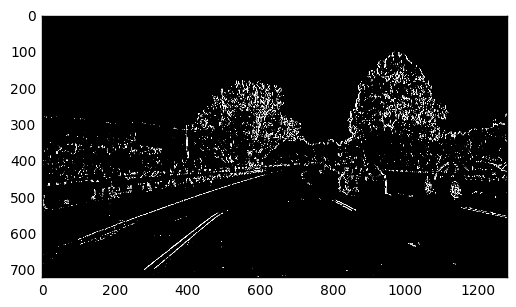

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

grad_binary_x_ti = abs_sobel_thresh(undist_ti, orient='x', thresh_min=30, thresh_max=100)
plt.imshow(grad_binary_x_ti, cmap='gray')

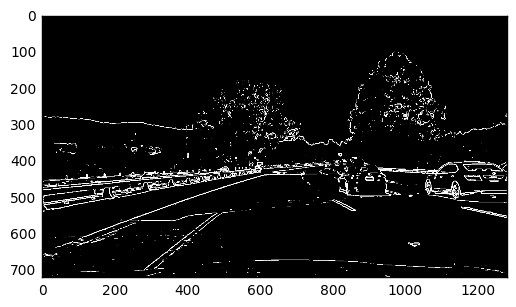

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

mag_binary_ti = mag_thresh(undist_ti, sobel_kernel=3, mag_thresh=(50, 200))
_, mag_binary_ti = cv2.threshold(mag_binary_ti,0,255,cv2.THRESH_BINARY)
mag_binary_ti = cv2.cvtColor(mag_binary_ti, cv2.COLOR_GRAY2RGB)
plt.imshow(mag_binary_ti, cmap='gray')

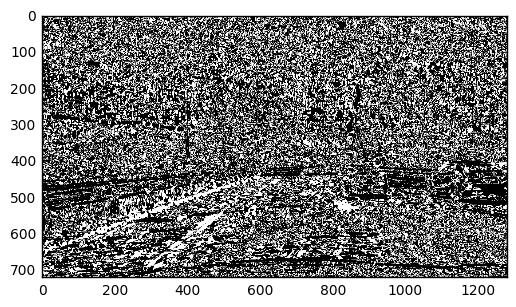

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output.astype('uint8')

dir_binary_ti = dir_threshold(undist_ti, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_binary_ti, cmap='gray')

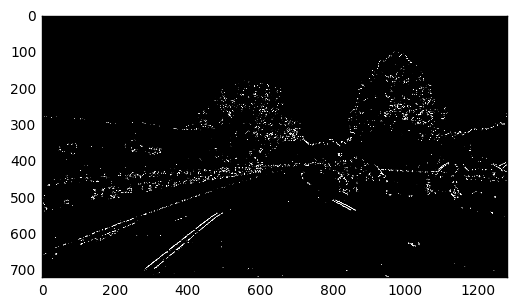

In [8]:
def combine_sobel(image):
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=30, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=30, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 200))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined
combined_sobel = combine_sobel(undist_ti)
plt.imshow(combined_sobel, cmap='gray')

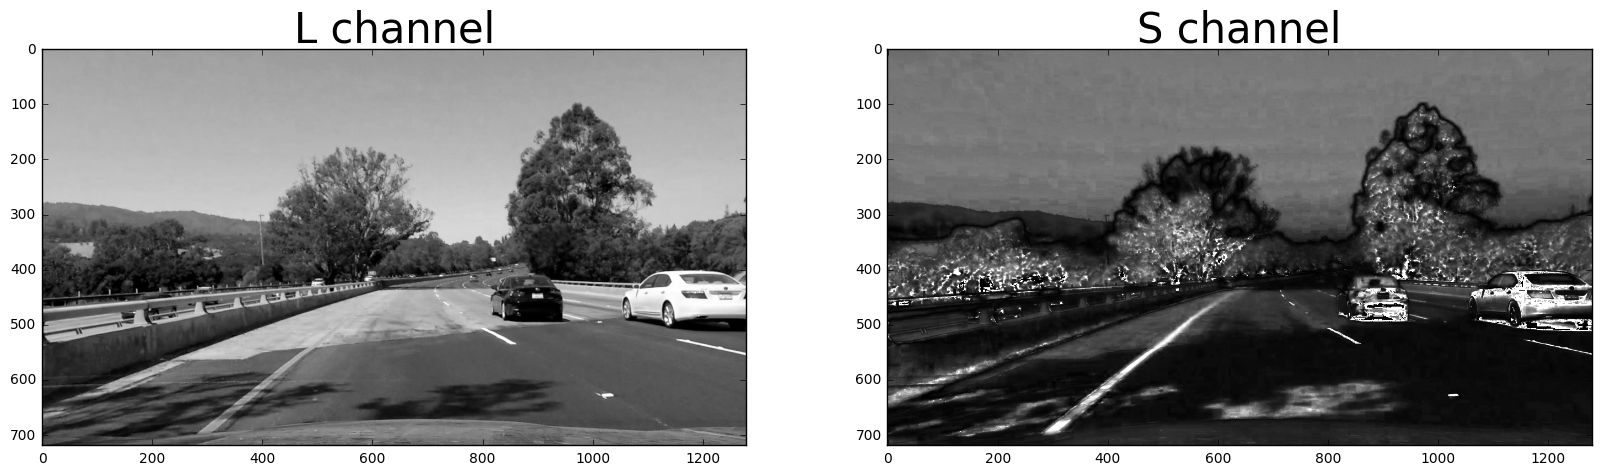

In [10]:
undist_hls = cv2.cvtColor(undist_ti, cv2.COLOR_RGB2HLS)
l_channel = undist_hls[:,:,1]
s_channel = undist_hls[:,:,2]
show_two_images(l_channel, s_channel, 'L channel', 'S channel')

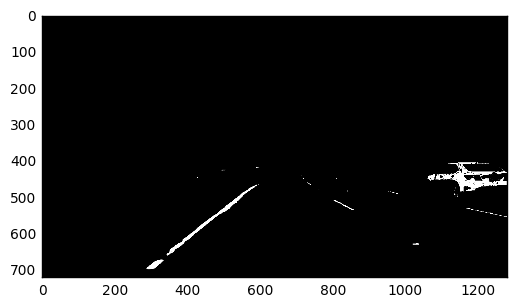

In [11]:
def combine_ls(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = image[:,:,1]
    s_channel = image[:,:,2]
    combined = np.zeros_like(s_channel)
    combined[(s_channel > 150) & (s_channel <= 255) & (l_channel > 100) & (l_channel <= 255)] = 1
    return combined
combined_ls = combine_ls(undist_ti)
plt.imshow(combined_ls, cmap='gray')

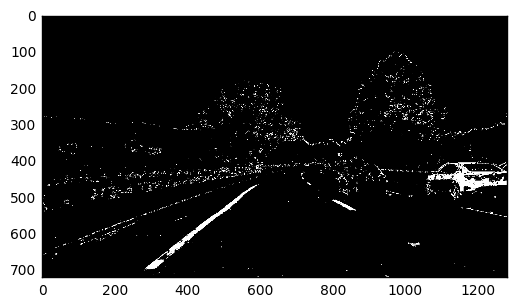

In [12]:
combined = np.zeros_like(combined_sobel)
combined[(combined_sobel == 1) | (combined_ls == 1)] = 1
plt.imshow(combined, cmap='gray')

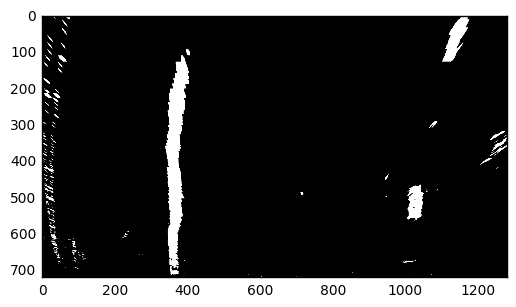

In [13]:
src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img_size = (combined.shape[1], combined.shape[0])
binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap='gray')

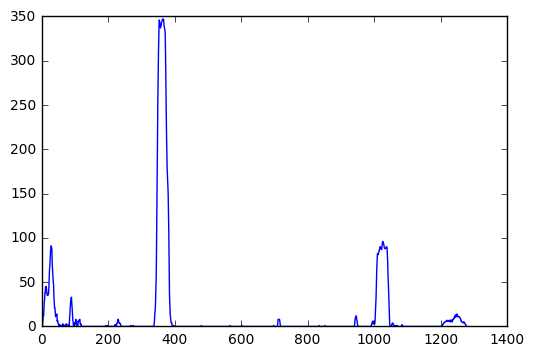

In [14]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [24]:
class Window():
    def __init__(self, xlow, xhigh, ylow, yhigh):
        self.xlow = xlow
        self.xhigh = xhigh
        self.ylow = ylow
        self.yhigh = yhigh
        
    @classmethod
    def from_image(cls, image_height, window_height, number, margin, center):
        ylow = image_height - (number + 1) * window_height
        yhigh = image_height - number * window_height
        xlow = center - margin
        xhigh = center + margin
        return cls(xlow, xhigh, ylow, yhigh)
    
    def draw(self, image):
        cv2.rectangle(image, (self.xlow, self.ylow), (self.xhigh, self.yhigh), (0, 255, 0), 2)
        
    def get_nonzero_inds(self, nonzerox, nonzeroy):
        nonzero_inds = ((nonzeroy >= self.ylow) & (nonzeroy < self.yhigh) & 
                        (nonzerox >= self.xlow) & (nonzerox < self.xhigh)).nonzero()[0]
        return nonzero_inds


In [31]:
def get_peaks(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

def get_nonzero_pixels(binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox, nonzeroy

def sliding_fit(binary_warped, nwindows, margin, minpix):
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    leftx_base, rightx_base = get_peaks(binary_warped)
    # Choose the number of sliding windows
    
    # Set height of windows
    image_height = binary_warped.shape[0]
    window_height = np.int(image_height/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzerox, nonzeroy = get_nonzero_pixels(binary_warped)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin

    # Set minimum number of pixels found to recenter window
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_lane_windows = []
    right_lane_windows = []
    # Step through the windows one by one
    for next_window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        left_w = Window.from_image(image_height, window_height, next_window, margin, leftx_current)
        right_w = Window.from_image(image_height, window_height, next_window, margin, rightx_current)
        left_lane_windows.append(left_w)
        right_lane_windows.append(right_w)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = left_w.get_nonzero_inds(nonzerox, nonzeroy)
        good_right_inds = right_w.get_nonzero_inds(nonzerox, nonzeroy)
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_lane_inds, right_lane_inds, left_fit, right_fit, left_lane_windows, right_lane_windows

(720,)
(720,)


(720, 0)

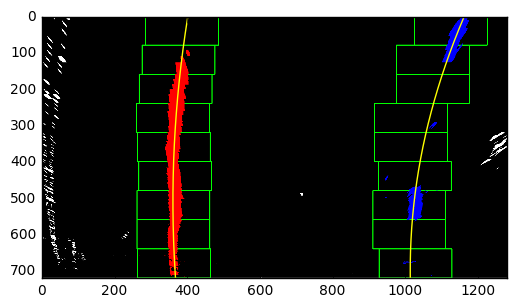

In [32]:
def get_plot_points(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

nwindows = 9
margin = 100
minpix = 50
left_lane_inds, right_lane_inds, left_fit, right_fit, left_windows, right_windows = sliding_fit(binary_warped, nwindows, margin, minpix)

# Draw the windows on the visualization image
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
for left_window, right_window in zip(left_windows, right_windows):
    left_window.draw(out_img)
    right_window.draw(out_img)

nonzerox, nonzeroy = get_nonzero_pixels(binary_warped)

# Generate x and y values for plotting
left_fitx, right_fitx, ploty = get_plot_points(img, left_fit, right_fit)
print(left_fitx.shape)
print(ploty.shape)
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [33]:
def easy_fit(binary_warped, left_fit, right_fit, margin):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzerox, nonzeroy = get_nonzero_pixels(binary_warped)
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_lane_inds, right_lane_inds, left_fit, right_fit

(720,)
(720,)


(720, 0)

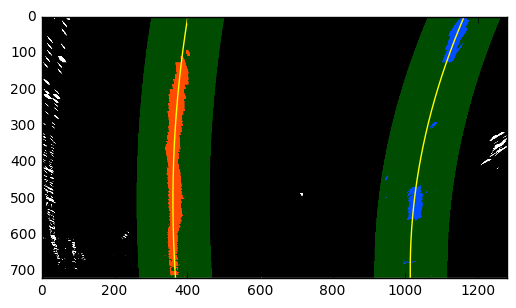

In [34]:
left_lane_inds, right_lane_inds, left_fit, right_fit = easy_fit(binary_warped, left_fit, right_fit, margin)
# Generate x and y values for plotting
left_fitx, right_fitx, ploty = get_plot_points(img, left_fit, right_fit)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
print(left_fitx.shape)
print(ploty.shape)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

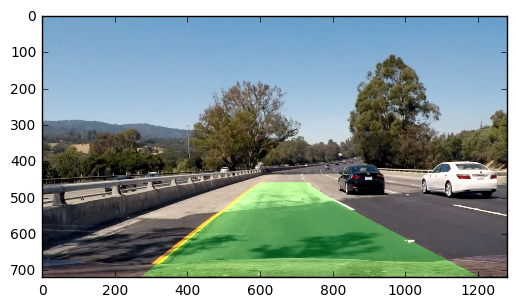

In [35]:
def draw_lane(image, binary_warped, left_fit, right_fit, m_inv):
    left_fitx, right_fitx, ploty = get_plot_points(img, left_fit, right_fit)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

drawed_lane = draw_lane(test_image, binary_warped, left_fit, right_fit, Minv)
plt.imshow(drawed_lane)

In [43]:
class Line():
    def __init__(self):
        self.xfit = None
        self.fit = None
        self.frame = 0

In [52]:
src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
left_line = Line()
right_line = Line()

def euclidean_distances(x1, x2, y1, y2):
    p1 = np.dstack((x1, y1))[0]
    p2 = np.dstack((x2, y2))[0]
    distances = np.linalg.norm(p1-p2, axis=1)
    return distances


def process_image(image):
    global left_line
    global right_line
    image = undistort(image, mtx, dist)
    combined_sobel = combine_sobel(image)
    combined_ls = combine_ls(image)
    binary = np.zeros_like(combined_sobel)
    binary[(combined_sobel == 1) | (combined_ls == 1)] = 1
    img_size = (binary.shape[1], binary.shape[0])
    binary_warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
    if left_line.frame == 0:
        _, _, left_fit, right_fit, left_windows, right_windows = sliding_fit(binary_warped, nwindows, margin, minpix)
    else:        
        _, _, left_fit, right_fit = easy_fit(binary_warped, left_line.fit, right_line.fit, margin)
    left_fitx, right_fitx, ploty = get_plot_points(binary_warped, left_fit, right_fit)
    if left_line.frame > 0:
        left_distances = euclidean_distances(left_line.xfit, left_fitx, ploty, ploty)
        right_distances = euclidean_distances(right_line.xfit, right_fitx, ploty, ploty)
        threshold = 30
        if max(left_distances) > threshold:
            left_fit = left_line.fit
            print(left_line.frame, 'l', max(left_distances))
        elif max(right_distances) > threshold:
            right_fit = right_line.fit
            print(right_line.frame, 'r', max(right_distances))    
    left_line.fit, left_line.xfit = left_fit, left_fitx
    right_line.fit, right_line.xfit = right_fit, right_fitx
    left_line.frame += 1
    right_line.frame += 1
    image = draw_lane(image, binary_warped, left_fit, right_fit, Minv)
    cv2.imwrite('frames/frame' + str(frame) + '.png', image)    
    return image

In [53]:
output = 'processed.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video processed.mp4
[MoviePy] Writing video processed.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<03:57,  5.31it/s]


  0%|          | 2/1261 [00:00<04:03,  5.16it/s]


  0%|          | 3/1261 [00:00<03:56,  5.32it/s]


  0%|          | 4/1261 [00:00<03:53,  5.39it/s]


  0%|          | 5/1261 [00:00<03:50,  5.45it/s]


  0%|          | 6/1261 [00:01<03:49,  5.47it/s]


  1%|          | 7/1261 [00:01<03:52,  5.39it/s]


  1%|          | 8/1261 [00:01<03:58,  5.26it/s]


  1%|          | 9/1261 [00:01<03:50,  5.44it/s]


  1%|          | 10/1261 [00:01<03:44,  5.56it/s]


  1%|          | 11/1261 [00:02<03:45,  5.53it/s]


  1%|          | 12/1261 [00:02<03:55,  5.29it/s]


  1%|          | 13/1261 [00:02<03:50,  5.41it/s]


  1%|          | 14/1261 [00:02<03:45,  5.52it/s]


  1%|          | 15/1261 [00:02<03:42,  5.59it/s]

15 r 36.9158815959





  1%|▏         | 16/1261 [00:02<03:45,  5.52it/s]


  1%|▏         | 17/1261 [00:03<03:45,  5.51it/s]


  1%|▏         | 18/1261 [00:03<03:48,  5.45it/s]


  2%|▏         | 19/1261 [00:03<03:44,  5.53it/s]


  2%|▏         | 20/1261 [00:03<03:44,  5.53it/s]


  2%|▏         | 21/1261 [00:03<03:42,  5.57it/s]


  2%|▏         | 22/1261 [00:04<03:40,  5.62it/s]


  2%|▏         | 23/1261 [00:04<03:40,  5.62it/s]


  2%|▏         | 24/1261 [00:04<03:49,  5.39it/s]


  2%|▏         | 25/1261 [00:04<03:47,  5.43it/s]


  2%|▏         | 26/1261 [00:04<03:50,  5.35it/s]


  2%|▏         | 27/1261 [00:04<03:46,  5.45it/s]


  2%|▏         | 28/1261 [00:05<03:41,  5.56it/s]


  2%|▏         | 29/1261 [00:05<03:38,  5.63it/s]


  2%|▏         | 30/1261 [00:05<03:38,  5.63it/s]


  2%|▏         | 31/1261 [00:05<03:44,  5.47it/s]


  3%|▎         | 32/1261 [00:05<03:51,  5.30it/s]


  3%|▎         | 33/1261 [00:06<03:48,  5.38it/s]


  3%|▎         | 34/1261 [00:06<03:53,  5.27it/s]


  3%|▎   

36 r 30.0399495354





  3%|▎         | 37/1261 [00:06<03:39,  5.58it/s]


  3%|▎         | 38/1261 [00:06<03:39,  5.56it/s]


  3%|▎         | 39/1261 [00:07<03:41,  5.53it/s]


  3%|▎         | 40/1261 [00:07<03:40,  5.53it/s]


  3%|▎         | 41/1261 [00:07<03:51,  5.27it/s]


  3%|▎         | 42/1261 [00:07<03:46,  5.37it/s]


  3%|▎         | 43/1261 [00:07<03:45,  5.41it/s]


  3%|▎         | 44/1261 [00:08<03:45,  5.39it/s]


  4%|▎         | 45/1261 [00:08<03:46,  5.37it/s]


  4%|▎         | 46/1261 [00:08<03:46,  5.37it/s]


  4%|▎         | 47/1261 [00:08<03:52,  5.22it/s]


  4%|▍         | 48/1261 [00:08<03:51,  5.24it/s]


  4%|▍         | 49/1261 [00:09<03:50,  5.27it/s]


  4%|▍         | 50/1261 [00:09<03:45,  5.37it/s]


  4%|▍         | 51/1261 [00:09<03:43,  5.40it/s]


  4%|▍         | 52/1261 [00:09<03:40,  5.49it/s]


  4%|▍         | 53/1261 [00:09<03:39,  5.51it/s]


  4%|▍         | 54/1261 [00:09<03:37,  5.56it/s]


  4%|▍         | 55/1261 [00:10<03:37,  5.55it/s]


  4%|▍   

87 r 33.6923910278





  7%|▋         | 88/1261 [00:16<03:43,  5.25it/s]


  7%|▋         | 89/1261 [00:16<03:38,  5.37it/s]


  7%|▋         | 90/1261 [00:16<03:35,  5.44it/s]

90 r 31.8094614509





  7%|▋         | 91/1261 [00:16<03:33,  5.48it/s]


  7%|▋         | 92/1261 [00:16<03:30,  5.55it/s]


  7%|▋         | 93/1261 [00:17<03:34,  5.44it/s]


  7%|▋         | 94/1261 [00:17<03:37,  5.36it/s]


  8%|▊         | 95/1261 [00:17<03:31,  5.51it/s]


  8%|▊         | 96/1261 [00:17<03:30,  5.53it/s]


  8%|▊         | 97/1261 [00:17<03:30,  5.54it/s]


  8%|▊         | 98/1261 [00:17<03:27,  5.60it/s]


  8%|▊         | 99/1261 [00:18<03:29,  5.55it/s]


  8%|▊         | 100/1261 [00:18<03:34,  5.42it/s]


  8%|▊         | 101/1261 [00:18<03:33,  5.42it/s]


  8%|▊         | 102/1261 [00:18<03:38,  5.30it/s]


  8%|▊         | 103/1261 [00:18<03:35,  5.37it/s]


  8%|▊         | 104/1261 [00:19<03:35,  5.37it/s]


  8%|▊         | 105/1261 [00:19<03:31,  5.47it/s]


  8%|▊         | 106/1261 [00:19<03:27,  5.56it/s]


  8%|▊         | 107/1261 [00:19<03:24,  5.63it/s]


  9%|▊         | 108/1261 [00:19<03:23,  5.67it/s]


  9%|▊         | 109/1261 [00:19<03:22,  5.68it/s]



159 r 37.0834111539





 13%|█▎        | 160/1261 [00:29<03:17,  5.57it/s]


 13%|█▎        | 161/1261 [00:29<03:14,  5.65it/s]


 13%|█▎        | 162/1261 [00:29<03:12,  5.71it/s]


 13%|█▎        | 163/1261 [00:29<03:15,  5.61it/s]


 13%|█▎        | 164/1261 [00:29<03:20,  5.46it/s]


 13%|█▎        | 165/1261 [00:29<03:19,  5.50it/s]


 13%|█▎        | 166/1261 [00:30<03:18,  5.53it/s]


 13%|█▎        | 167/1261 [00:30<03:18,  5.52it/s]


 13%|█▎        | 168/1261 [00:30<03:17,  5.52it/s]


 13%|█▎        | 169/1261 [00:30<03:15,  5.58it/s]


 13%|█▎        | 170/1261 [00:30<03:13,  5.64it/s]


 14%|█▎        | 171/1261 [00:31<03:11,  5.69it/s]


 14%|█▎        | 172/1261 [00:31<03:12,  5.66it/s]


 14%|█▎        | 173/1261 [00:31<03:14,  5.60it/s]


 14%|█▍        | 174/1261 [00:31<03:29,  5.19it/s]


 14%|█▍        | 175/1261 [00:31<03:23,  5.35it/s]


 14%|█▍        | 176/1261 [00:31<03:17,  5.48it/s]


 14%|█▍        | 177/1261 [00:32<03:25,  5.27it/s]


 14%|█▍        | 178/1261 [00:32<03:31,  5.

186 r 40.7526790324





 15%|█▍        | 187/1261 [00:34<03:08,  5.69it/s]


 15%|█▍        | 188/1261 [00:34<03:08,  5.71it/s]


 15%|█▍        | 189/1261 [00:34<03:07,  5.72it/s]


 15%|█▌        | 190/1261 [00:34<03:06,  5.76it/s]


 15%|█▌        | 191/1261 [00:34<03:10,  5.61it/s]


 15%|█▌        | 192/1261 [00:34<03:12,  5.57it/s]


 15%|█▌        | 193/1261 [00:35<03:12,  5.54it/s]


 15%|█▌        | 194/1261 [00:35<03:10,  5.61it/s]


 15%|█▌        | 195/1261 [00:35<03:10,  5.59it/s]


 16%|█▌        | 196/1261 [00:35<03:13,  5.50it/s]

196 r 35.4253071538
197 r 45.6086707418





 16%|█▌        | 197/1261 [00:35<03:13,  5.50it/s]


 16%|█▌        | 198/1261 [00:35<03:09,  5.60it/s]


 16%|█▌        | 199/1261 [00:36<03:08,  5.64it/s]

199 r 42.8946002396





 16%|█▌        | 200/1261 [00:36<03:06,  5.69it/s]


 16%|█▌        | 201/1261 [00:36<03:04,  5.74it/s]


 16%|█▌        | 202/1261 [00:36<03:03,  5.76it/s]


 16%|█▌        | 203/1261 [00:36<03:03,  5.77it/s]


 16%|█▌        | 204/1261 [00:37<03:03,  5.76it/s]


 16%|█▋        | 205/1261 [00:37<03:03,  5.76it/s]


 16%|█▋        | 206/1261 [00:37<03:02,  5.77it/s]


 16%|█▋        | 207/1261 [00:37<03:03,  5.76it/s]


 16%|█▋        | 208/1261 [00:37<03:04,  5.69it/s]


 17%|█▋        | 209/1261 [00:37<03:10,  5.51it/s]


 17%|█▋        | 210/1261 [00:38<03:13,  5.42it/s]


 17%|█▋        | 211/1261 [00:38<03:15,  5.37it/s]


 17%|█▋        | 212/1261 [00:38<03:14,  5.38it/s]


 17%|█▋        | 213/1261 [00:38<03:12,  5.46it/s]


 17%|█▋        | 214/1261 [00:38<03:12,  5.44it/s]


 17%|█▋        | 215/1261 [00:39<03:08,  5.55it/s]


 17%|█▋        | 216/1261 [00:39<03:10,  5.48it/s]


 17%|█▋        | 217/1261 [00:39<03:11,  5.46it/s]


 17%|█▋        | 218/1261 [00:39<03:10,  5.

305 r 39.12827526





 24%|██▍       | 306/1261 [00:55<02:45,  5.76it/s]


 24%|██▍       | 307/1261 [00:55<02:45,  5.75it/s]


 24%|██▍       | 308/1261 [00:55<02:44,  5.79it/s]


 25%|██▍       | 309/1261 [00:55<02:44,  5.80it/s]


 25%|██▍       | 310/1261 [00:55<02:48,  5.65it/s]


 25%|██▍       | 311/1261 [00:56<02:50,  5.58it/s]


 25%|██▍       | 312/1261 [00:56<02:50,  5.57it/s]


 25%|██▍       | 313/1261 [00:56<02:48,  5.61it/s]


 25%|██▍       | 314/1261 [00:56<02:46,  5.68it/s]


 25%|██▍       | 315/1261 [00:56<02:45,  5.72it/s]


 25%|██▌       | 316/1261 [00:56<02:44,  5.76it/s]


 25%|██▌       | 317/1261 [00:57<02:44,  5.76it/s]


 25%|██▌       | 318/1261 [00:57<02:43,  5.78it/s]


 25%|██▌       | 319/1261 [00:57<02:43,  5.77it/s]


 25%|██▌       | 320/1261 [00:57<02:42,  5.79it/s]


 25%|██▌       | 321/1261 [00:57<02:44,  5.73it/s]


 26%|██▌       | 322/1261 [00:58<02:43,  5.75it/s]


 26%|██▌       | 323/1261 [00:58<02:44,  5.69it/s]


 26%|██▌       | 324/1261 [00:58<02:43,  5.

536 r 32.6799695873





 43%|████▎     | 537/1261 [01:36<02:07,  5.69it/s]


 43%|████▎     | 538/1261 [01:37<02:06,  5.72it/s]


 43%|████▎     | 539/1261 [01:37<02:06,  5.73it/s]


 43%|████▎     | 540/1261 [01:37<02:06,  5.72it/s]


 43%|████▎     | 541/1261 [01:37<02:06,  5.69it/s]


 43%|████▎     | 542/1261 [01:37<02:05,  5.72it/s]


 43%|████▎     | 543/1261 [01:37<02:05,  5.72it/s]


 43%|████▎     | 544/1261 [01:38<02:04,  5.75it/s]


 43%|████▎     | 545/1261 [01:38<02:04,  5.76it/s]


 43%|████▎     | 546/1261 [01:38<02:03,  5.78it/s]


 43%|████▎     | 547/1261 [01:38<02:04,  5.75it/s]


 43%|████▎     | 548/1261 [01:38<02:03,  5.78it/s]


 44%|████▎     | 549/1261 [01:39<02:03,  5.78it/s]


 44%|████▎     | 550/1261 [01:39<02:03,  5.76it/s]

550 r 112.073501108
551 r 107.127116024





 44%|████▎     | 551/1261 [01:39<02:04,  5.72it/s]


 44%|████▍     | 552/1261 [01:39<02:03,  5.75it/s]


 44%|████▍     | 553/1261 [01:39<02:02,  5.77it/s]


 44%|████▍     | 554/1261 [01:39<02:02,  5.77it/s]


 44%|████▍     | 555/1261 [01:40<02:02,  5.78it/s]


 44%|████▍     | 556/1261 [01:40<02:01,  5.79it/s]


 44%|████▍     | 557/1261 [01:40<02:01,  5.79it/s]


 44%|████▍     | 558/1261 [01:40<02:01,  5.80it/s]


 44%|████▍     | 559/1261 [01:40<02:01,  5.78it/s]

559 r 42.5801400482
560 l 47.9284305542





 44%|████▍     | 560/1261 [01:40<02:01,  5.76it/s]


 44%|████▍     | 561/1261 [01:41<02:01,  5.74it/s]


 45%|████▍     | 562/1261 [01:41<02:01,  5.74it/s]


 45%|████▍     | 563/1261 [01:41<02:01,  5.77it/s]

563 l 33.5901427321
564 l 45.7665926142





 45%|████▍     | 564/1261 [01:41<02:00,  5.77it/s]


 45%|████▍     | 565/1261 [01:41<01:59,  5.80it/s]


 45%|████▍     | 566/1261 [01:41<01:59,  5.82it/s]


 45%|████▍     | 567/1261 [01:42<02:00,  5.75it/s]

567 l 41.1647024656





 45%|████▌     | 568/1261 [01:42<02:00,  5.74it/s]


 45%|████▌     | 569/1261 [01:42<02:00,  5.76it/s]


 45%|████▌     | 570/1261 [01:42<01:59,  5.77it/s]


 45%|████▌     | 571/1261 [01:42<01:59,  5.77it/s]


 45%|████▌     | 572/1261 [01:43<01:59,  5.76it/s]


 45%|████▌     | 573/1261 [01:43<01:59,  5.78it/s]


 46%|████▌     | 574/1261 [01:43<01:58,  5.79it/s]


 46%|████▌     | 575/1261 [01:43<01:57,  5.82it/s]


 46%|████▌     | 576/1261 [01:43<01:57,  5.84it/s]


 46%|████▌     | 577/1261 [01:43<01:56,  5.85it/s]


 46%|████▌     | 578/1261 [01:44<01:56,  5.84it/s]

578 l 42.548195323





 46%|████▌     | 579/1261 [01:44<01:56,  5.85it/s]


 46%|████▌     | 580/1261 [01:44<01:56,  5.85it/s]


 46%|████▌     | 581/1261 [01:44<01:56,  5.84it/s]


 46%|████▌     | 582/1261 [01:44<01:56,  5.83it/s]


 46%|████▌     | 583/1261 [01:44<01:55,  5.85it/s]


 46%|████▋     | 584/1261 [01:45<01:55,  5.86it/s]


 46%|████▋     | 585/1261 [01:45<01:55,  5.84it/s]

585 l 35.6023973615
586 l 47.2322181347





 46%|████▋     | 586/1261 [01:45<01:55,  5.85it/s]


 47%|████▋     | 587/1261 [01:45<01:54,  5.87it/s]


 47%|████▋     | 588/1261 [01:45<01:54,  5.86it/s]


 47%|████▋     | 589/1261 [01:45<01:54,  5.87it/s]


 47%|████▋     | 590/1261 [01:46<01:54,  5.85it/s]

590 l 57.1139334174
591 l 93.5244688881





 47%|████▋     | 591/1261 [01:46<01:54,  5.83it/s]


 47%|████▋     | 592/1261 [01:46<01:54,  5.83it/s]


 47%|████▋     | 593/1261 [01:46<01:54,  5.85it/s]


 47%|████▋     | 594/1261 [01:46<01:54,  5.85it/s]


 47%|████▋     | 595/1261 [01:46<01:54,  5.84it/s]


 47%|████▋     | 596/1261 [01:47<01:53,  5.85it/s]


 47%|████▋     | 597/1261 [01:47<01:54,  5.79it/s]


 47%|████▋     | 598/1261 [01:47<01:54,  5.81it/s]


 48%|████▊     | 599/1261 [01:47<01:54,  5.80it/s]

599 l 58.8996754705





 48%|████▊     | 600/1261 [01:47<01:53,  5.81it/s]


 48%|████▊     | 601/1261 [01:47<01:53,  5.79it/s]


 48%|████▊     | 602/1261 [01:48<01:53,  5.79it/s]


 48%|████▊     | 603/1261 [01:48<01:53,  5.81it/s]


 48%|████▊     | 604/1261 [01:48<01:53,  5.77it/s]


 48%|████▊     | 605/1261 [01:48<01:53,  5.80it/s]


 48%|████▊     | 606/1261 [01:48<01:53,  5.79it/s]

606 l 44.6229054068





 48%|████▊     | 607/1261 [01:49<01:53,  5.78it/s]


 48%|████▊     | 608/1261 [01:49<01:52,  5.78it/s]


 48%|████▊     | 609/1261 [01:49<01:52,  5.78it/s]


 48%|████▊     | 610/1261 [01:49<01:52,  5.77it/s]


 48%|████▊     | 611/1261 [01:49<01:52,  5.77it/s]


 49%|████▊     | 612/1261 [01:49<01:52,  5.77it/s]


 49%|████▊     | 613/1261 [01:50<01:52,  5.76it/s]


 49%|████▊     | 614/1261 [01:50<01:52,  5.76it/s]


 49%|████▉     | 615/1261 [01:50<01:51,  5.77it/s]


 49%|████▉     | 616/1261 [01:50<01:52,  5.75it/s]


 49%|████▉     | 617/1261 [01:50<01:51,  5.76it/s]


 49%|████▉     | 618/1261 [01:50<01:51,  5.77it/s]


 49%|████▉     | 619/1261 [01:51<01:52,  5.73it/s]

619 l 34.8545083568





 49%|████▉     | 620/1261 [01:51<01:52,  5.72it/s]


 49%|████▉     | 621/1261 [01:51<01:51,  5.74it/s]


 49%|████▉     | 622/1261 [01:51<01:52,  5.67it/s]


 49%|████▉     | 623/1261 [01:51<01:52,  5.69it/s]


 49%|████▉     | 624/1261 [01:51<01:51,  5.69it/s]


 50%|████▉     | 625/1261 [01:52<01:51,  5.71it/s]

625 l 56.3475160894





 50%|████▉     | 626/1261 [01:52<01:50,  5.73it/s]


 50%|████▉     | 627/1261 [01:52<01:51,  5.67it/s]


 50%|████▉     | 628/1261 [01:52<01:50,  5.71it/s]


 50%|████▉     | 629/1261 [01:52<01:53,  5.55it/s]


 50%|████▉     | 630/1261 [01:53<01:52,  5.59it/s]

630 l 49.8129378977





 50%|█████     | 631/1261 [01:53<01:54,  5.52it/s]


 50%|█████     | 632/1261 [01:53<01:53,  5.54it/s]


 50%|█████     | 633/1261 [01:53<01:54,  5.51it/s]


 50%|█████     | 634/1261 [01:53<01:54,  5.49it/s]


 50%|█████     | 635/1261 [01:53<01:53,  5.53it/s]

635 l 33.7041841883
636 l 35.3558258124





 50%|█████     | 636/1261 [01:54<01:54,  5.45it/s]


 51%|█████     | 637/1261 [01:54<01:53,  5.52it/s]


 51%|█████     | 638/1261 [01:54<01:52,  5.56it/s]


 51%|█████     | 639/1261 [01:54<01:52,  5.52it/s]


 51%|█████     | 640/1261 [01:54<01:54,  5.40it/s]

640 l 32.7202738288
641 l 33.4126984955





 51%|█████     | 641/1261 [01:55<01:55,  5.39it/s]


 51%|█████     | 642/1261 [01:55<01:55,  5.36it/s]


 51%|█████     | 643/1261 [01:55<01:55,  5.37it/s]


 51%|█████     | 644/1261 [01:55<01:55,  5.36it/s]


 51%|█████     | 645/1261 [01:55<01:54,  5.39it/s]


 51%|█████     | 646/1261 [01:55<01:52,  5.45it/s]


 51%|█████▏    | 647/1261 [01:56<01:50,  5.55it/s]


 51%|█████▏    | 648/1261 [01:56<01:50,  5.55it/s]


 51%|█████▏    | 649/1261 [01:56<01:50,  5.55it/s]


 52%|█████▏    | 650/1261 [01:56<01:48,  5.63it/s]


 52%|█████▏    | 651/1261 [01:56<01:47,  5.68it/s]


 52%|█████▏    | 652/1261 [01:57<01:46,  5.73it/s]


 52%|█████▏    | 653/1261 [01:57<01:46,  5.72it/s]


 52%|█████▏    | 654/1261 [01:57<01:46,  5.73it/s]


 52%|█████▏    | 655/1261 [01:57<01:45,  5.76it/s]


 52%|█████▏    | 656/1261 [01:57<01:45,  5.75it/s]


 52%|█████▏    | 657/1261 [01:57<01:44,  5.77it/s]


 52%|█████▏    | 658/1261 [01:58<01:45,  5.74it/s]


 52%|█████▏    | 659/1261 [01:58<01:46,  5.

984 r 50.0952269614
985 r 63.8622153369





 78%|███████▊  | 985/1261 [02:57<00:51,  5.35it/s]


 78%|███████▊  | 986/1261 [02:58<00:50,  5.45it/s]


 78%|███████▊  | 987/1261 [02:58<00:49,  5.50it/s]

987 r 84.5618277893
988 r 176.843323641





 78%|███████▊  | 988/1261 [02:58<00:49,  5.54it/s]


 78%|███████▊  | 989/1261 [02:58<00:48,  5.59it/s]


 79%|███████▊  | 990/1261 [02:58<00:48,  5.63it/s]


 79%|███████▊  | 991/1261 [02:58<00:48,  5.59it/s]


 79%|███████▊  | 992/1261 [02:59<00:48,  5.60it/s]


 79%|███████▊  | 993/1261 [02:59<00:47,  5.63it/s]


 79%|███████▉  | 994/1261 [02:59<00:47,  5.60it/s]


 79%|███████▉  | 995/1261 [02:59<00:47,  5.63it/s]


 79%|███████▉  | 996/1261 [02:59<00:47,  5.59it/s]


 79%|███████▉  | 997/1261 [02:59<00:47,  5.61it/s]


 79%|███████▉  | 998/1261 [03:00<00:46,  5.61it/s]


 79%|███████▉  | 999/1261 [03:00<00:46,  5.58it/s]


 79%|███████▉  | 1000/1261 [03:00<00:46,  5.61it/s]


 79%|███████▉  | 1001/1261 [03:00<00:46,  5.54it/s]


 79%|███████▉  | 1002/1261 [03:00<00:46,  5.55it/s]

1002 l 36.1990418517
1003 r 31.9147801606





 80%|███████▉  | 1003/1261 [03:01<00:46,  5.52it/s]


 80%|███████▉  | 1004/1261 [03:01<00:46,  5.52it/s]

1004 l 34.3277081138
1005 r 35.5713349367





 80%|███████▉  | 1005/1261 [03:01<00:46,  5.49it/s]


 80%|███████▉  | 1006/1261 [03:01<00:46,  5.50it/s]

1006 l 78.6099487354





 80%|███████▉  | 1007/1261 [03:01<00:46,  5.51it/s]


 80%|███████▉  | 1008/1261 [03:01<00:45,  5.54it/s]

1008 l 47.7756788801





 80%|████████  | 1009/1261 [03:02<00:45,  5.53it/s]


 80%|████████  | 1010/1261 [03:02<00:45,  5.56it/s]


 80%|████████  | 1011/1261 [03:02<00:45,  5.53it/s]


 80%|████████  | 1012/1261 [03:02<00:44,  5.54it/s]

1012 l 69.3557560586





 80%|████████  | 1013/1261 [03:02<00:45,  5.43it/s]


 80%|████████  | 1014/1261 [03:03<00:46,  5.30it/s]

1014 r 51.3585072979





 80%|████████  | 1015/1261 [03:03<00:46,  5.28it/s]


 81%|████████  | 1016/1261 [03:03<00:45,  5.36it/s]


 81%|████████  | 1017/1261 [03:03<00:45,  5.32it/s]


 81%|████████  | 1018/1261 [03:03<00:45,  5.37it/s]

1018 l 34.982494616
1019 l 32.5439720617





 81%|████████  | 1019/1261 [03:03<00:44,  5.40it/s]


 81%|████████  | 1020/1261 [03:04<00:44,  5.42it/s]


 81%|████████  | 1021/1261 [03:04<00:44,  5.40it/s]

1021 l 33.2658329458





 81%|████████  | 1022/1261 [03:04<00:44,  5.34it/s]


 81%|████████  | 1023/1261 [03:04<00:44,  5.39it/s]


 81%|████████  | 1024/1261 [03:04<00:43,  5.39it/s]


 81%|████████▏ | 1025/1261 [03:05<00:44,  5.36it/s]


 81%|████████▏ | 1026/1261 [03:05<00:44,  5.33it/s]

1026 l 58.9450656596





 81%|████████▏ | 1027/1261 [03:05<00:43,  5.37it/s]


 82%|████████▏ | 1028/1261 [03:05<00:42,  5.43it/s]


 82%|████████▏ | 1029/1261 [03:05<00:42,  5.46it/s]


 82%|████████▏ | 1030/1261 [03:06<00:42,  5.47it/s]


 82%|████████▏ | 1031/1261 [03:06<00:41,  5.48it/s]


 82%|████████▏ | 1032/1261 [03:06<00:42,  5.45it/s]


 82%|████████▏ | 1033/1261 [03:06<00:41,  5.47it/s]


 82%|████████▏ | 1034/1261 [03:06<00:41,  5.49it/s]


 82%|████████▏ | 1035/1261 [03:06<00:41,  5.47it/s]


 82%|████████▏ | 1036/1261 [03:07<00:41,  5.48it/s]

1036 l 32.7253798134





 82%|████████▏ | 1037/1261 [03:07<00:40,  5.48it/s]


 82%|████████▏ | 1038/1261 [03:07<00:40,  5.50it/s]


 82%|████████▏ | 1039/1261 [03:07<00:40,  5.50it/s]


 82%|████████▏ | 1040/1261 [03:07<00:40,  5.49it/s]


 83%|████████▎ | 1041/1261 [03:08<00:39,  5.52it/s]


 83%|████████▎ | 1042/1261 [03:08<00:39,  5.56it/s]


 83%|████████▎ | 1043/1261 [03:08<00:39,  5.57it/s]


 83%|████████▎ | 1044/1261 [03:08<00:38,  5.59it/s]


 83%|████████▎ | 1045/1261 [03:08<00:38,  5.58it/s]

1045 l 35.3523002955
1046 l 39.3216922258





 83%|████████▎ | 1046/1261 [03:08<00:38,  5.60it/s]


 83%|████████▎ | 1047/1261 [03:09<00:37,  5.63it/s]


 83%|████████▎ | 1048/1261 [03:09<00:37,  5.65it/s]

1048 l 36.2684431179





 83%|████████▎ | 1049/1261 [03:09<00:37,  5.66it/s]


 83%|████████▎ | 1050/1261 [03:09<00:37,  5.63it/s]


 83%|████████▎ | 1051/1261 [03:09<00:37,  5.58it/s]


 83%|████████▎ | 1052/1261 [03:09<00:37,  5.60it/s]


 84%|████████▎ | 1053/1261 [03:10<00:36,  5.63it/s]


 84%|████████▎ | 1054/1261 [03:10<00:36,  5.67it/s]

1054 l 44.3843287964





 84%|████████▎ | 1055/1261 [03:10<00:36,  5.69it/s]


 84%|████████▎ | 1056/1261 [03:10<00:36,  5.69it/s]


 84%|████████▍ | 1057/1261 [03:10<00:35,  5.70it/s]


 84%|████████▍ | 1058/1261 [03:11<00:35,  5.70it/s]


 84%|████████▍ | 1059/1261 [03:11<00:36,  5.51it/s]


 84%|████████▍ | 1060/1261 [03:11<00:36,  5.50it/s]


 84%|████████▍ | 1061/1261 [03:11<00:36,  5.52it/s]


 84%|████████▍ | 1062/1261 [03:11<00:35,  5.55it/s]


 84%|████████▍ | 1063/1261 [03:11<00:35,  5.51it/s]

1063 l 38.9871665965





 84%|████████▍ | 1064/1261 [03:12<00:35,  5.53it/s]


 84%|████████▍ | 1065/1261 [03:12<00:35,  5.57it/s]


 85%|████████▍ | 1066/1261 [03:12<00:34,  5.58it/s]


 85%|████████▍ | 1067/1261 [03:12<00:35,  5.53it/s]


 85%|████████▍ | 1068/1261 [03:12<00:34,  5.57it/s]


 85%|████████▍ | 1069/1261 [03:13<00:34,  5.58it/s]


 85%|████████▍ | 1070/1261 [03:13<00:34,  5.59it/s]


 85%|████████▍ | 1071/1261 [03:13<00:34,  5.57it/s]


 85%|████████▌ | 1072/1261 [03:13<00:33,  5.56it/s]


 85%|████████▌ | 1073/1261 [03:13<00:33,  5.59it/s]


 85%|████████▌ | 1074/1261 [03:13<00:33,  5.60it/s]


 85%|████████▌ | 1075/1261 [03:14<00:33,  5.62it/s]


 85%|████████▌ | 1076/1261 [03:14<00:32,  5.63it/s]


 85%|████████▌ | 1077/1261 [03:14<00:32,  5.63it/s]


 85%|████████▌ | 1078/1261 [03:14<00:32,  5.62it/s]


 86%|████████▌ | 1079/1261 [03:14<00:32,  5.52it/s]


 86%|████████▌ | 1080/1261 [03:15<00:33,  5.45it/s]


 86%|████████▌ | 1081/1261 [03:15<00:33,  5.44it/s]


 86%|████████▌ | 1082/126

1116 r 33.6478635568





 89%|████████▊ | 1117/1261 [03:21<00:26,  5.54it/s]


 89%|████████▊ | 1118/1261 [03:21<00:25,  5.54it/s]


 89%|████████▊ | 1119/1261 [03:22<00:25,  5.60it/s]


 89%|████████▉ | 1120/1261 [03:22<00:24,  5.64it/s]


 89%|████████▉ | 1121/1261 [03:22<00:24,  5.64it/s]


 89%|████████▉ | 1122/1261 [03:22<00:24,  5.65it/s]


 89%|████████▉ | 1123/1261 [03:22<00:24,  5.63it/s]


 89%|████████▉ | 1124/1261 [03:22<00:24,  5.68it/s]

1124 r 33.1032408957





 89%|████████▉ | 1125/1261 [03:23<00:24,  5.60it/s]


 89%|████████▉ | 1126/1261 [03:23<00:23,  5.64it/s]


 89%|████████▉ | 1127/1261 [03:23<00:23,  5.68it/s]


 89%|████████▉ | 1128/1261 [03:23<00:23,  5.71it/s]


 90%|████████▉ | 1129/1261 [03:23<00:23,  5.71it/s]


 90%|████████▉ | 1130/1261 [03:24<00:22,  5.73it/s]


 90%|████████▉ | 1131/1261 [03:24<00:22,  5.71it/s]


 90%|████████▉ | 1132/1261 [03:24<00:23,  5.59it/s]


 90%|████████▉ | 1133/1261 [03:24<00:23,  5.53it/s]


 90%|████████▉ | 1134/1261 [03:24<00:23,  5.47it/s]


 90%|█████████ | 1135/1261 [03:24<00:23,  5.35it/s]


 90%|█████████ | 1136/1261 [03:25<00:23,  5.35it/s]


 90%|█████████ | 1137/1261 [03:25<00:22,  5.45it/s]


 90%|█████████ | 1138/1261 [03:25<00:22,  5.54it/s]


 90%|█████████ | 1139/1261 [03:25<00:21,  5.55it/s]


 90%|█████████ | 1140/1261 [03:25<00:21,  5.58it/s]


 90%|█████████ | 1141/1261 [03:26<00:21,  5.52it/s]


 91%|█████████ | 1142/1261 [03:26<00:21,  5.56it/s]


 91%|█████████ | 1143/126

[MoviePy] Done.
[MoviePy] >>>> Video ready: processed.mp4 

CPU times: user 4min 7s, sys: 4.11 s, total: 4min 11s
Wall time: 3min 48s
